In [475]:
from brainiak.isc import isc,bootstrap_isc,compute_summary_statistic
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [476]:
froot = '/data00/layerfMRI/'
datafld = froot + 'Github_repo/layerfMRI/analyses/dual_ISC/'
os.listdir(datafld)

['log_summary.csv',
 'fixing_log_file.Rmd',
 '.gitignore',
 'M_OR_S_JU_time_courses_thr100_bin6_isc.csv',
 'log_summary_FIXED.csv',
 'M_OR_S_JU_time_courses_thr100_bin10.csv',
 'log_summary_OLE_no_Estimated_Duration.csv',
 'dual_ISC_development_v8.html',
 'M_OR_S_JU_time_courses_thr100_bin6_isc.png',
 'ANOVA_M_S_JU_time_courses_thr10_bin10_isc.png',
 'data_native',
 'M_OR_S_JU_time_courses_thr100_bin10_isc.png',
 'ANOVA_M_S_JU_time_courses_thr10_bin10.csv',
 'dual_ISC_development_v8.Rmd',
 'M_OR_S_JU_time_courses_thr100_bin10_isc.csv',
 'labels_juelich.csv',
 'M_OR_S_JU_time_courses_thr100_bin6.csv',
 'ANOVA_M_S_JU_time_courses_thr10_bin6_isc.png',
 'log_summary_FIXED_MRGNCY.csv',
 'ANOVA_M_S_JU_time_courses_thr10_bin6.csv',
 'native_MNI_transformation',
 'OLE',
 'TC_4_lorenzo',
 'fixing_log_file.html']

In [477]:
nbins = 10
method = 'ANOVA_M_S'

In [478]:
f = f'{method}_JU_time_courses_thr10_bin{nbins}.csv'

In [479]:
logsumm = (pd
           .read_csv(froot+ 'logs/log_summary.csv')
           .assign(fmri = lambda d:
                   froot + 
                   'regdata/sub_' + d['subject'].apply(lambda n: '{:02d}'.format(n)) +
                   '/ses_' + d['session'].apply(lambda n: '{:02d}'.format(n)) +
                   '/func/task_' + d['task'].apply(lambda n: '{:01d}'.format(n)) +
                   '_run_' + d['run'].apply(lambda n: '{:01d}'.format(n)) +
                   '_4D_MNI.nii.gz'
                  )
           .assign(fmri_missing = lambda d : d['fmri'].apply(lambda s: os.path.isfile(s) != True))
           
          )


movie_length = {}

for mv in logsumm.Title.unique():
    durations = logsumm.loc[lambda d : d['Title'] == mv].ExpectedDuration.unique()
    if len(durations) != 1:
        print('Warning! More than one duration found')
        movie_length[mv] = np.min(durations)
    else:
        movie_length[mv] = durations[0]



In [480]:
def r2numpy(rvec):
    
    return np.array(rvec[2:-1].split(', '),dtype = 'float')

# def trim_movielength(dataf):
    
#     trimmed = dataf['tc_mean_unfolded'][:movie_length[dataf['muvi']]]
    
#     return trimmed
    
    
def stdize(a):
    
    return (a - np.average(a)) / np.std(a)



In [481]:
# Read dataframe
df = pd.read_csv(datafld + f)

# Transform timecourses into numpy arrays and standardize them
df['tc_mean_unfolded'] = (df['tc_mean_unfolded']
                          .map(r2numpy)
                         )

# Correct for movies that are missing the last frame
df['measured_movl'] = df.apply(lambda row : len(row['tc_mean_unfolded']), axis = 1)
df['expected_movl'] = df.apply(lambda row : movie_length[row['muvi']], axis = 1)

corrected_movl = (df
                  .loc[lambda d : d['expected_movl'] > d['measured_movl']]
                  .groupby('muvi')
                  .apply(lambda d: np.min(d['measured_movl']))
                 )

for m in dict(corrected_movl):
    movie_length[m] = corrected_movl[m]
#####################################################
    
df['tc_mean_trimmed'] = (df
                         .apply(lambda row : row['tc_mean_unfolded'][:movie_length[row['muvi']]], axis = 1)
                         .map(stdize)
                        )

df['measured_movl'] = df.apply(lambda row : len(row['tc_mean_trimmed']), axis = 1)

In [482]:
# Get movie names
movie_names = {}
for c,gdf in df.groupby(['contrast']):
    movie_names[c] = gdf.sort_values(['muvi']).muvi.unique()

# Concatenate movie and task
cdf  = pd.DataFrame()
count = 0

for [c,s,j,d],gdf in df.groupby(['contrast','sub','JU','D_bins']):

    gdf = gdf.sort_values(['muvi','run'])
    movie_list = gdf['muvi'].unique()

    try:
        same = (movie_names[c] == movie_list).all()
    except:
        same = False
    if not same:
        print(f'Error! contrast {c} subject {s} JU {j} D_bins {d}')
    else:
        count += 1
    
    concatenated = np.hstack(gdf['tc_mean_trimmed'])
    
    temp_df = gdf.iloc[0][['contrast','sub','JU','D_bins']]
    temp_df['tc_concatenated'] = concatenated
    
    cdf = cdf.append(temp_df)

/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  app.launch_new_instance()


Error! contrast Motion subject sub_02 JU 35 D_bins 6
Error! contrast Motion subject sub_02 JU 35 D_bins 7
Error! contrast Motion subject sub_02 JU 35 D_bins 8
Error! contrast Motion subject sub_03 JU 35 D_bins 7
Error! contrast Motion subject sub_03 JU 35 D_bins 8
Error! contrast Motion subject sub_05 JU 35 D_bins 7
Error! contrast Motion subject sub_06 JU 35 D_bins 10
Error! contrast Motion subject sub_10 JU 35 D_bins 10
Error! contrast Motion subject sub_11 JU 35 D_bins 8
Error! contrast Motion subject sub_11 JU 65 D_bins 1
Error! contrast Motion subject sub_14 JU 35 D_bins 10
Error! contrast Motion subject sub_14 JU 65 D_bins 7
Error! contrast Scrambled subject sub_02 JU 35 D_bins 6
Error! contrast Scrambled subject sub_02 JU 35 D_bins 7
Error! contrast Scrambled subject sub_02 JU 35 D_bins 8
Error! contrast Scrambled subject sub_03 JU 35 D_bins 7
Error! contrast Scrambled subject sub_03 JU 35 D_bins 8
Error! contrast Scrambled subject sub_05 JU 35 D_bins 7
Error! contrast Scrambled

In [483]:
## Extra layer of safety

# This checks what length of the concatenated arrays is the most common and delets combinations of JU and Dbins that are different
for c,contrast_df in cdf.groupby('contrast'):
    
    T = int(contrast_df['tc_concatenated'].apply(lambda d: len(d)).mode())
    unmatching = contrast_df.loc[contrast_df['tc_concatenated'].apply(lambda d: len(d)) != T][['D_bins','JU']].drop_duplicates()
    
    
    for i,unm in unmatching.iterrows():
        
        cdf = cdf.drop(cdf.loc[lambda d : (d['contrast'] == c)&(d['JU']==unm['JU'])&(d['D_bins']==unm['D_bins'])].index)
        
        print('Contrast {}: bin {} of JU {} deleted'.format(c,unm['D_bins'],unm['JU']))


    # This checks what length of the concatenated arrays is the most common and delets combinations of JU and Dbins that are different
    grouped_df = contrast_df.groupby(['D_bins','JU']).apply(lambda d:len(d['sub']))
    N_sub = int(grouped_df.mode())
    grouped_df = grouped_df.reset_index()
    unmatching = grouped_df.loc[lambda d: d[0] != N_sub]
    
    for i,unm in unmatching.iterrows():
        
        cdf = cdf.drop(cdf.loc[lambda d : (d['contrast'] == c)&(d['JU']==unm['JU'])&(d['D_bins']==unm['D_bins'])].index)
        
        print('!!Contrast {}: bin {} of JU {} deleted'.format(c,unm['D_bins'],unm['JU']))

Contrast Motion: bin 5.0 of JU 35.0 deleted
Contrast Motion: bin 6.0 of JU 35.0 deleted
Contrast Motion: bin 7.0 of JU 35.0 deleted
Contrast Motion: bin 8.0 of JU 35.0 deleted
Contrast Motion: bin 9.0 of JU 65.0 deleted
Contrast Motion: bin 10.0 of JU 65.0 deleted
Contrast Motion: bin 10.0 of JU 35.0 deleted
Contrast Motion: bin 1.0 of JU 35.0 deleted
Contrast Motion: bin 9.0 of JU 35.0 deleted
Contrast Motion: bin 1.0 of JU 65.0 deleted
Contrast Motion: bin 5.0 of JU 65.0 deleted
Contrast Motion: bin 7.0 of JU 65.0 deleted
!!Contrast Motion: bin 8.0 of JU 35.0 deleted
!!Contrast Motion: bin 9.0 of JU 35.0 deleted
!!Contrast Motion: bin 10.0 of JU 35.0 deleted
!!Contrast Motion: bin 10.0 of JU 65.0 deleted
Contrast Scrambled: bin 5.0 of JU 35.0 deleted
Contrast Scrambled: bin 6.0 of JU 35.0 deleted
Contrast Scrambled: bin 7.0 of JU 35.0 deleted
Contrast Scrambled: bin 8.0 of JU 35.0 deleted
Contrast Scrambled: bin 9.0 of JU 65.0 deleted
Contrast Scrambled: bin 10.0 of JU 65.0 deleted
C

In [484]:
cdf['D_bins'] = cdf['D_bins'].astype(int)
cdf['JU'] = cdf['JU'].astype(int)
cdf = cdf.sort_values(['contrast','sub','JU','D_bins'])


isc_column = np.array([])

for c,contrast_df in cdf.groupby('contrast'):

    iscarr = np.array(list(contrast_df
     .groupby('sub')
     .apply(lambda d: np.array(list(d['tc_concatenated'])).T)
    ))
    
    iscarr = np.moveaxis(iscarr,0,2)
    
    isc_data =  isc(iscarr)
    isc_column = np.append(isc_column,isc_data.ravel())

cdf['isc'] = np.arctanh(isc_column)

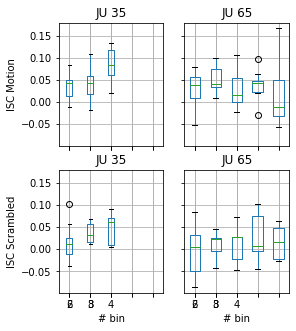

In [485]:
ncols = cdf['JU'].nunique()
nrows = cdf['contrast'].nunique()

fig,axarr = plt.subplots(ncols=ncols,nrows=nrows, sharex = True, sharey = True, figsize = (ncols*2,5))
axarr = np.ravel(axarr)

for i,((c,j),plotdf) in enumerate(cdf.groupby(['contrast','JU'])):   
    
    plotdf.boxplot(column = ['isc'], by = 'D_bins',ax=axarr[i])
    axarr[i].set_title('JU {}'.format(int(j)))
    axarr[i].set_ylabel('ISC {}'.format(c))
    
axarr = axarr.reshape(nrows,ncols)
for ax in axarr[0]:
    ax.set_xlabel('')
for ax in axarr[1]:
    ax.set_xlabel('# bin')
for ax in axarr[:,1:].ravel():
    ax.set_ylabel('')

fig.suptitle('')
plt.savefig(datafld + f.replace('.csv','_isc.png'), dpi = 300)


In [486]:
cdf.to_csv(datafld + f.replace('.csv','_isc.csv'))

In [487]:
cdf

,D_bins,JU,contrast,sub,tc_concatenated,isc
291,2,35,Motion,sub_02,"[-1.2250526561928006, 1.9748335012407756, 0.38...",0.013847
292,3,35,Motion,sub_02,"[-0.7933225294325823, 1.1849844371683977, 1.21...",0.018392
293,4,35,Motion,sub_02,"[-0.547032535222668, 1.7014497689879295, -0.42...",0.083286
297,2,65,Motion,sub_02,"[-0.38402030592014025, 0.28414969697405434, 0....",0.019998
298,3,65,Motion,sub_02,"[0.42664368946697223, 0.5817391876441558, -0.2...",0.039713
...,...,...,...,...,...,...
10797,2,65,Scrambled,sub_14,"[-0.9883034388807886, 0.8079668014444629, 1.77...",0.083864
10798,3,65,Scrambled,sub_14,"[0.9738302258414254, -0.22826230178152618, 1.1...",-0.015797
10799,4,65,Scrambled,sub_14,"[0.9761494637649474, 0.7361228575440394, -0.09...",-0.021946
10801,6,65,Scrambled,sub_14,"[0.27928004628999653, 1.9594971663999148, 0.12...",0.029176
